In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

In [3]:
!git clone https://github.com/alexhepburn/pixel-cnn-pp pixelcnn
!unzip /content/drive/MyDrive/Colab/Archive-1f46.zip -d ./

Cloning into 'pixelcnn'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 457 (delta 29), reused 25 (delta 25), pack-reused 423
Receiving objects: 100% (457/457), 7.81 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (61/61), done.
unzip:  cannot find or open /content/drive/MyDrive/Colab/Archive-1f46.zip, /content/drive/MyDrive/Colab/Archive-1f46.zip.zip or /content/drive/MyDrive/Colab/Archive-1f46.zip.ZIP.


In [4]:
# Para descargar el modelo
# https://mega.nz/folder/W7IhST7R#PV7Pbet8Q07GxVLGnmQrZg

%load_ext autoreload
%autoreload 2
import sys
import torch
sys.path.append('/content/pixelcnn/')
from pixelcnn.model import *
from pixelcnn.utils import *

obs = (3, 32, 32)
input_channels = obs[0]

args = {}
args['nr_resnet'] = 5
args['nr_filters'] = 160
args['input_channels'] = obs[0]
args['nr_logistic_mix'] = 10

model = PixelCNN(nr_resnet=args['nr_resnet'], nr_filters=args['nr_filters'],
            input_channels=input_channels, nr_logistic_mix=args['nr_logistic_mix'])
model = model.cuda()
model = model.eval()
param_dict = torch.load('/content/drive/MyDrive/RESEARCH/Prob_vs_Perc/pixelcnn/pcnn_lr.0.00040_nr-resnet5_nr-filters160_889.pth', map_location='cpu')
param_dict = {k[7:]:v for k, v in param_dict.items()}
model.load_state_dict(param_dict)

loss_op   = lambda real, fake : discretized_mix_logistic_loss(real, fake)


def log_prob(x):
  x = x.cuda()
  y = model(x)
  return discretized_mix_logistic_loss(x, y)


def prob_grad(x):
  x = torch.tensor(x, requires_grad=True)
  prob = log_prob(x)
  grad = torch.autograd.functional.jacobian(log_prob, x)
  return prob.detach().cpu().numpy(), grad.detach().cpu().numpy()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:
batch_size = 20

from keras.datasets import cifar10
(x_train_ori, _), (x_test_ori, _) = cifar10.load_data()
x_train = x_train_ori.astype('float32')/255
x_test = x_test_ori.astype('float32')/255


170498071/170498071 [==============================] - 3s 0us/step


In [6]:
x_train = np.transpose(x_train,(0,3,1,2))
x_test = np.transpose(x_test,(0,3,1,2))
print(x_train.shape)

(50000, 3, 32, 32)


In [9]:

x_np = x_train[0:1,:,:,:]
x_np.shape

(1, 3, 32, 32)

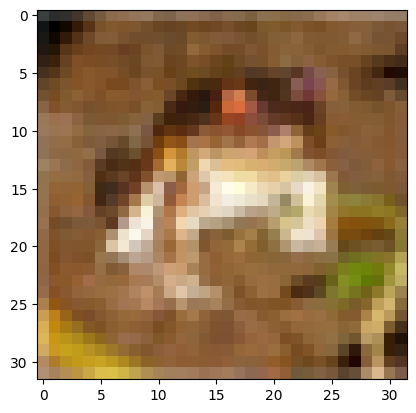

In [11]:
import matplotlib.pyplot as plt


plt.imshow(np.transpose(x_np[0],(1,2,0)))

In [12]:
# CALCULAMOS EL GRADIENTE DE LA PROBABILIDAD
GG = prob_grad(x_np)

In [16]:
#probabilidada
GG[0]

array([-6154.8276], dtype=float32)

In [24]:
MM = np.max(np.abs(np.transpose(GG[1][0,0],(1,2,0))))

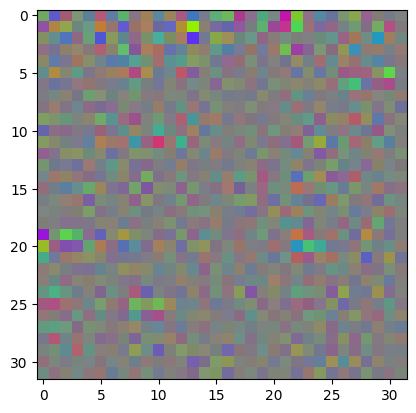

In [25]:
# Gradiente de la probabilidad respecto a la imagen
plt.imshow(0.5+np.transpose(GG[1][0,0],(1,2,0))/(2*MM))

<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


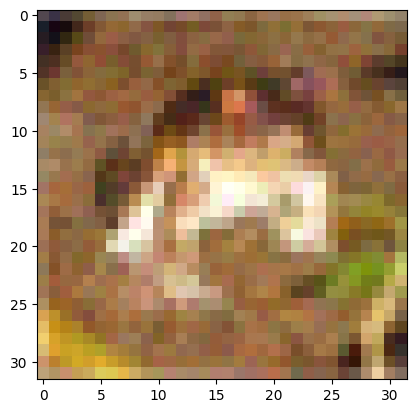

In [18]:
# CALCULAMOS EL GRADIENTE DE LA PROBABILIDAD DEL RUIDO

x_np_noise = x_np+0.1*np.random.rand(3,32,32)

plt.imshow(np.transpose(x_np_noise[0],(1,2,0)))

GG_noise = prob_grad(torch.tensor(np.float32(x_np_noise), requires_grad=True))

In [19]:
GG_noise[0]

array([-10311.667], dtype=float32)

<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


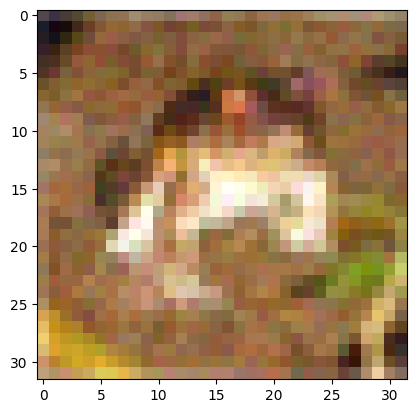

In [32]:
# Modificamos la imagen ruidosa para subirle la probabilidad

Derivada = GG[1][0]

salto = 0.0000005

X_limpiada = x_np_noise + salto*Derivada
plt.imshow(np.transpose(X_limpiada[0],(1,2,0)))
GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))


In [33]:
GG_limpiada[0]

array([-10310.421], dtype=float32)

<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


0 [-10307.274]


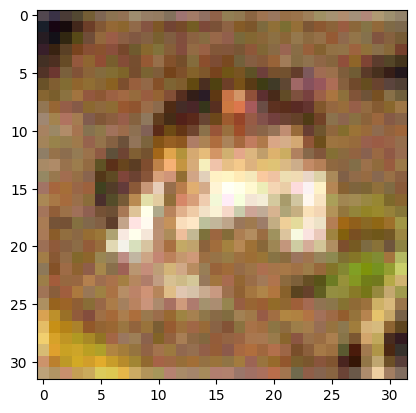

1 [-10302.895]
2 [-10298.525]
3 [-10294.158]
4 [-10289.792]
5 [-10285.422]
6 [-10281.049]
7 [-10277.779]
8 [-10273.41]
9 [-10269.052]
10 [-10264.711]
11 [-10260.396]
12 [-10256.104]
13 [-10251.827]
14 [-10247.563]
15 [-10243.308]
16 [-10239.058]
17 [-10234.811]
18 [-10230.564]
19 [-10226.319]
20 [-10223.583]
21 [-10219.333]
22 [-10215.082]
23 [-10210.827]
24 [-10206.572]
25 [-10202.313]
26 [-10198.055]
27 [-10193.792]
28 [-10189.525]
29 [-10185.256]
30 [-10180.982]
31 [-10176.705]
32 [-10172.422]
33 [-10168.134]
34 [-10163.84]
35 [-10159.541]
36 [-10155.234]
37 [-10150.922]
38 [-10146.604]
39 [-10142.277]
40 [-10137.946]
41 [-10133.607]
42 [-10129.262]
43 [-10124.908]
44 [-10120.547]
45 [-10116.18]
46 [-10111.804]
47 [-10107.419]
48 [-10103.027]
49 [-10098.625]
50 [-10094.213]
51 [-10089.795]
52 [-10085.365]
53 [-10080.927]
54 [-10076.479]
55 [-10072.021]
56 [-10067.554]
57 [-10063.077]
58 [-10058.591]
59 [-10054.096]
60 [-10049.59]
61 [-10045.074]
62 [-10040.551]
63 [-10036.019]
64 [-

100 [-9861.021]


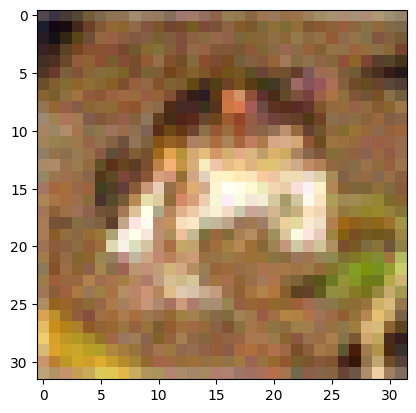

101 [-9856.068]
102 [-9851.104]
103 [-9846.125]
104 [-9841.132]
105 [-9836.128]
106 [-9831.109]
107 [-9826.076]
108 [-9821.033]
109 [-9815.974]
110 [-9810.902]
111 [-9805.817]
112 [-9800.719]
113 [-9795.607]
114 [-9790.4795]
115 [-9785.338]
116 [-9780.181]
117 [-9775.008]
118 [-9769.82]
119 [-9764.617]
120 [-9759.396]
121 [-9754.162]
122 [-9748.91]
123 [-9743.644]
124 [-9738.359]
125 [-9733.061]
126 [-9727.744]
127 [-9722.412]
128 [-9720.689]
129 [-9715.32]
130 [-9709.934]
131 [-9704.529]
132 [-9695.486]
133 [-9693.67]
134 [-9688.212]
135 [-9682.735]
136 [-9677.237]
137 [-9671.721]
138 [-9666.182]
139 [-9657.014]
140 [-9655.041]
141 [-9649.4375]
142 [-9643.8125]
143 [-9638.166]
144 [-9628.897]
145 [-9626.811]
146 [-9621.102]
147 [-9615.375]
148 [-9609.625]
149 [-9600.262]
150 [-9598.07]
151 [-9592.261]
152 [-9586.431]
153 [-9576.988]
154 [-9574.705]
155 [-9568.807]
156 [-9562.889]
157 [-9553.365]
158 [-9551.001]
159 [-9545.04]
160 [-9539.076]
161 [-9529.524]
162 [-9527.139]
163 [-9521.

200 [-9287.955]


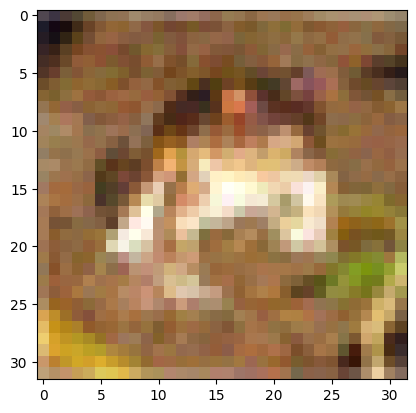

201 [-9284.976]
202 [-9278.455]
203 [-9268.402]
204 [-9265.363]
205 [-9255.28]
206 [-9252.199]
207 [-9245.588]
208 [-9235.457]
209 [-9232.307]
210 [-9225.633]
211 [-9215.449]
212 [-9212.225]
213 [-9202.005]
214 [-9198.728]
215 [-9188.469]
216 [-9185.139]
217 [-9178.309]
218 [-9167.992]
219 [-9164.585]
220 [-9154.23]
221 [-9150.77]
222 [-9140.376]
223 [-9136.861]
224 [-9129.867]
225 [-9119.412]
226 [-9115.807]
227 [-9105.301]
228 [-9101.63]
229 [-9091.076]
230 [-9087.346]
231 [-9076.75]
232 [-9072.97]
233 [-9062.334]
234 [-9058.496]
235 [-9047.809]
236 [-9043.891]
237 [-9033.123]
238 [-9029.119]
239 [-9018.301]
240 [-9014.25]
241 [-9003.386]
242 [-8999.258]
243 [-8988.3125]
244 [-8984.087]
245 [-8973.051]
246 [-8968.718]
247 [-8957.596]
248 [-8949.818]
249 [-8945.357]
250 [-8934.415]
251 [-8926.148]
252 [-8921.939]
253 [-8910.182]
254 [-8902.279]
255 [-8897.665]
256 [-8886.534]
257 [-8878.221]
258 [-8873.53]
259 [-8862.156]
260 [-8854.065]
261 [-8845.978]
262 [-8837.822]
263 [-8832.992]

300 [-8494.795]


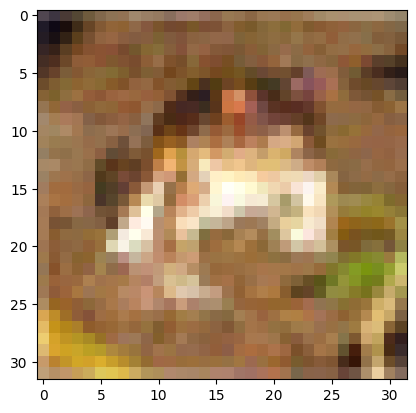

301 [-8485.334]
302 [-8475.198]
303 [-8465.918]
304 [-8454.9]
305 [-8445.068]
306 [-8434.983]
307 [-8426.831]
308 [-8414.882]
309 [-8404.855]
310 [-8395.87]
311 [-8384.73]
312 [-8375.141]
313 [-8365.184]
314 [-8357.139]
315 [-8344.527]
316 [-8333.588]
317 [-8323.567]
318 [-8312.439]
319 [-8302.899]
320 [-8290.699]
321 [-8279.899]
322 [-8269.166]
323 [-8258.753]
324 [-8249.658]
325 [-8245.776]
326 [-8230.707]
327 [-8218.656]
328 [-8206.52]
329 [-8195.938]
330 [-8184.076]
331 [-8173.4253]
332 [-8162.8467]
333 [-8154.5015]
334 [-8144.1533]
335 [-8133.367]
336 [-8121.5933]
337 [-8117.9736]
338 [-8101.6284]
339 [-8093.25]
340 [-8080.2437]
341 [-8067.929]
342 [-8057.684]
343 [-8044.7954]
344 [-8037.355]
345 [-8023.91]
346 [-8026.956]
347 [-8046.175]
348 [-8024.5967]
349 [-8012.417]
350 [-7988.425]
351 [-7988.819]
352 [-7969.9424]
353 [-7952.382]
354 [-7935.6094]
355 [-7926.8545]
356 [-7915.0566]
357 [-7903.4775]
358 [-7892.01]
359 [-7880.59]
360 [-7869.5166]
361 [-7859.2017]
362 [-7848.5615]

400 [-7424.7007]


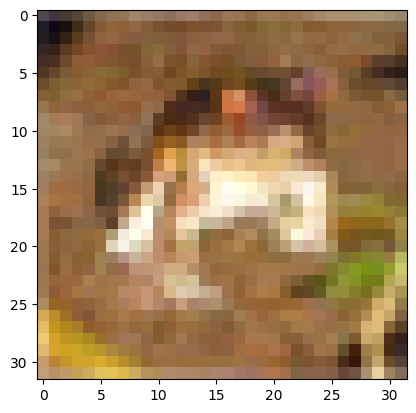

401 [-7412.165]
402 [-7399.206]
403 [-7402.347]
404 [-7387.89]
405 [-7413.772]
406 [-7386.3174]
407 [-7344.5693]
408 [-7326.663]
409 [-7330.0947]
410 [-7311.033]
411 [-7302.1313]
412 [-7295.4004]
413 [-7315.6377]
414 [-7294.006]
415 [-7272.5312]
416 [-7254.3013]
417 [-7265.4424]
418 [-7238.867]
419 [-7205.5444]
420 [-7190.462]
421 [-7184.7705]
422 [-7195.053]
423 [-7248.7705]
424 [-7223.754]
425 [-7198.8184]
426 [-7170.517]
427 [-7152.0166]
428 [-7130.214]
429 [-7114.488]
430 [-7097.5303]
431 [-7088.473]
432 [-7088.2915]
433 [-7110.438]
434 [-7081.5557]
435 [-7055.8037]
436 [-7036.9033]
437 [-7017.24]
438 [-7001.055]
439 [-6983.2793]
440 [-6971.3447]
441 [-6960.4346]
442 [-6949.6626]
443 [-6948.087]
444 [-6949.828]
445 [-6989.7485]
446 [-6958.783]
447 [-6933.201]
448 [-6910.8945]
449 [-6894.4307]
450 [-6884.794]
451 [-6861.156]
452 [-6854.1895]
453 [-6850.801]
454 [-6904.795]
455 [-6871.9116]
456 [-6851.3203]
457 [-6827.6675]
458 [-6807.328]
459 [-6794.23]
460 [-6782.1367]
461 [-6771.0

500 [-6463.46]


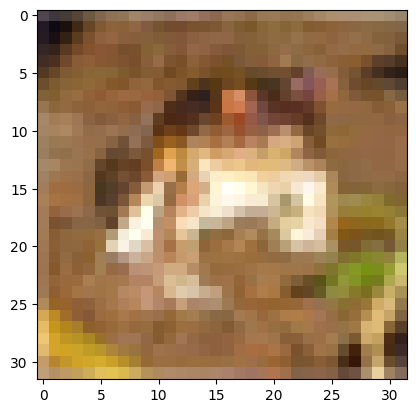

501 [-6456.0815]
502 [-6476.71]
503 [-6448.0557]
504 [-6430.2607]
505 [-6417.7744]
506 [-6414.502]
507 [-6429.139]
508 [-6433.0493]
509 [-6443.3467]
510 [-6432.4326]
511 [-6394.697]
512 [-6369.1943]
513 [-6353.664]
514 [-6342.322]
515 [-6342.6875]
516 [-6320.753]
517 [-6312.12]
518 [-6319.8467]
519 [-6355.641]
520 [-6321.463]
521 [-6298.081]
522 [-6278.7393]
523 [-6267.713]
524 [-6257.912]
525 [-6252.4453]
526 [-6259.8945]
527 [-6235.858]
528 [-6233.1875]
529 [-6238.7544]
530 [-6270.467]
531 [-6247.137]
532 [-6210.848]
533 [-6203.0967]
534 [-6195.0166]
535 [-6177.745]
536 [-6176.505]
537 [-6165.815]
538 [-6181.375]
539 [-6155.6206]
540 [-6141.9893]
541 [-6138.314]
542 [-6127.4478]
543 [-6127.0063]
544 [-6118.855]
545 [-6147.469]
546 [-6113.0713]
547 [-6093.6543]
548 [-6087.3145]
549 [-6074.077]
550 [-6069.3545]
551 [-6062.0034]
552 [-6074.1826]
553 [-6045.4727]
554 [-6036.6875]
555 [-6033.3115]
556 [-6037.9863]
557 [-6021.6924]
558 [-6054.533]
559 [-6017.4536]
560 [-5999.631]
561 [-599

600 [-5760.253]


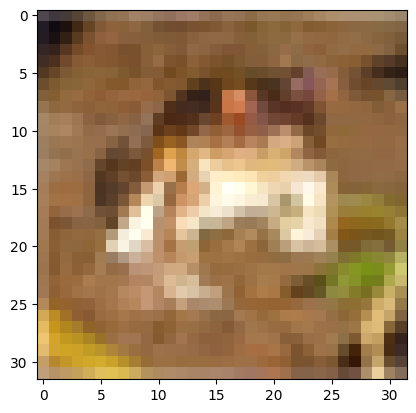

601 [-5728.783]
602 [-5711.3447]
603 [-5698.495]
604 [-5688.1616]
605 [-5675.525]
606 [-5672.008]
607 [-5684.8213]
608 [-5793.781]
609 [-5721.866]
610 [-5686.003]
611 [-5669.345]
612 [-5659.5605]
613 [-5635.9385]
614 [-5622.6504]
615 [-5612.596]
616 [-5610.625]
617 [-5651.7646]
618 [-5680.8906]
619 [-5636.631]
620 [-5604.1377]
621 [-5585.4434]
622 [-5572.3105]
623 [-5562.914]
624 [-5558.2227]
625 [-5560.8643]
626 [-5568.5137]
627 [-5541.367]
628 [-5528.549]
629 [-5519.3247]
630 [-5510.7173]
631 [-5508.5986]
632 [-5505.5605]
633 [-5500.6006]
634 [-5505.8677]
635 [-5482.0674]
636 [-5467.403]
637 [-5457.988]
638 [-5450.4814]
639 [-5444.8276]
640 [-5440.518]
641 [-5431.5103]
642 [-5444.813]
643 [-5444.69]
644 [-5477.0234]
645 [-5423.713]
646 [-5404.407]
647 [-5392.854]
648 [-5386.5283]
649 [-5378.291]
650 [-5379.5454]
651 [-5370.9126]
652 [-5368.8794]
653 [-5385.644]
654 [-5395.6045]
655 [-5359.282]
656 [-5341.2734]
657 [-5328.7954]
658 [-5323.5396]
659 [-5320.4595]
660 [-5330.747]
661 [-5

700 [-5095.363]


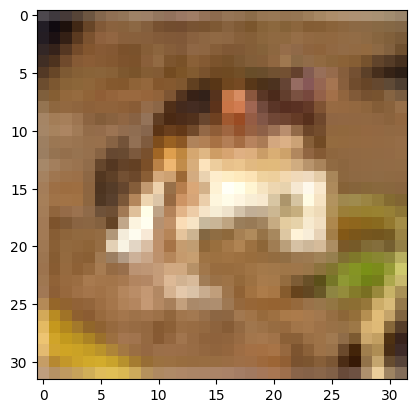

701 [-5117.1694]
702 [-5086.2573]
703 [-5082.263]
704 [-5074.991]
705 [-5088.288]
706 [-5076.0557]
707 [-5127.3096]
708 [-5074.8677]
709 [-5068.1934]
710 [-5045.159]
711 [-5041.975]
712 [-5041.011]
713 [-5080.1924]
714 [-5039.747]
715 [-5023.2153]
716 [-5022.271]
717 [-5034.6587]
718 [-5115.0186]
719 [-5052.7026]
720 [-5014.492]
721 [-4997.3545]
722 [-4984.144]
723 [-4987.6367]
724 [-5007.024]
725 [-5052.1436]
726 [-5016.1455]
727 [-5004.574]
728 [-4976.8345]
729 [-4962.501]
730 [-4961.5]
731 [-4988.9463]
732 [-4962.6367]
733 [-4975.8096]
734 [-4979.481]
735 [-4954.3677]
736 [-4936.399]
737 [-4981.164]
738 [-5040.056]
739 [-5037.255]
740 [-5005.9785]
741 [-4982.603]
742 [-4955.1104]
743 [-4942.5967]
744 [-4920.6055]
745 [-4926.2637]
746 [-4894.761]
747 [-4885.1367]
748 [-4895.073]
749 [-4874.7866]
750 [-4879.912]
751 [-5084.6475]
752 [-5122.091]
753 [-5076.1455]
754 [-5026.353]
755 [-5113.38]
756 [-5027.6367]
757 [-4980.456]
758 [-4956.438]
759 [-4926.3975]
760 [-4902.007]
761 [-4879.6

800 [-4807.4985]


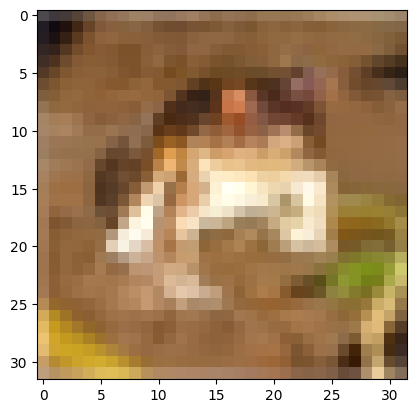

801 [-4739.255]
802 [-4712.1147]
803 [-4686.884]
804 [-4674.494]
805 [-4669.63]
806 [-4682.1387]
807 [-4687.996]
808 [-4731.385]
809 [-4684.9907]
810 [-4675.883]
811 [-4678.498]
812 [-4682.7363]
813 [-4659.205]
814 [-4633.9873]
815 [-4622.8823]
816 [-4627.9014]
817 [-4632.3867]
818 [-4627.072]
819 [-4621.74]
820 [-4694.856]
821 [-4705.76]
822 [-4651.3022]
823 [-4650.8076]
824 [-4624.1494]
825 [-4613.79]
826 [-4600.536]
827 [-4604.695]
828 [-4631.678]
829 [-4719.8496]
830 [-4681.559]
831 [-4652.4575]
832 [-4652.926]
833 [-4589.986]
834 [-4583.368]
835 [-4591.4326]
836 [-4656.1455]
837 [-4624.4053]
838 [-4587.4624]
839 [-4569.1226]
840 [-4575.9443]
841 [-4674.909]
842 [-4645.959]
843 [-4623.369]
844 [-4578.045]
845 [-4584.451]
846 [-4566.205]
847 [-4558.3535]
848 [-4541.461]
849 [-4554.4673]
850 [-4692.1655]
851 [-4679.0195]
852 [-4634.75]
853 [-4616.282]
854 [-4619.403]
855 [-4674.068]
856 [-4602.8013]
857 [-4566.291]
858 [-4544.4414]
859 [-4528.807]
860 [-4518.1875]
861 [-4531.34]
862 

900 [-4449.662]


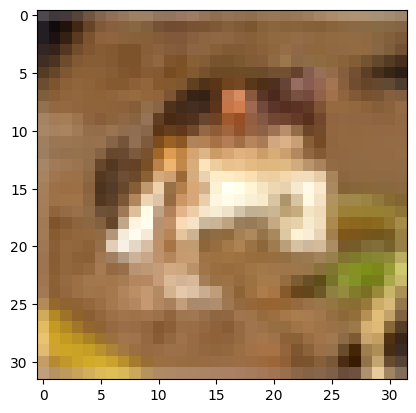

901 [-4437.0615]
902 [-4416.298]
903 [-4406.54]
904 [-4412.5083]
905 [-4434.505]
906 [-4493.9165]
907 [-4463.7725]
908 [-4432.6675]
909 [-4432.6123]
910 [-4417.284]
911 [-4430.231]
912 [-4415.8013]
913 [-4428.8486]
914 [-4402.4136]
915 [-4397.7305]
916 [-4384.9316]
917 [-4389.]
918 [-4482.957]
919 [-4465.973]
920 [-4422.4287]
921 [-4405.3613]
922 [-4394.1323]
923 [-4379.793]
924 [-4368.3037]
925 [-4364.655]
926 [-4374.0454]
927 [-4454.915]
928 [-4387.8105]
929 [-4365.298]
930 [-4370.902]
931 [-4366.0283]
932 [-4364.234]
933 [-4395.9097]
934 [-4431.3535]
935 [-4420.766]
936 [-4433.835]
937 [-4390.8057]
938 [-4365.052]
939 [-4356.909]
940 [-4349.3174]
941 [-4436.6416]
942 [-4378.664]
943 [-4345.702]
944 [-4337.606]
945 [-4337.366]
946 [-4378.4355]
947 [-4351.339]
948 [-4410.249]
949 [-4353.328]
950 [-4377.1094]
951 [-4332.767]
952 [-4322.93]
953 [-4363.4546]
954 [-4340.327]
955 [-4319.1196]
956 [-4325.1865]
957 [-4318.6533]
958 [-4406.764]
959 [-4374.119]
960 [-4334.0312]
961 [-4331.29]


1000 [-4229.01]


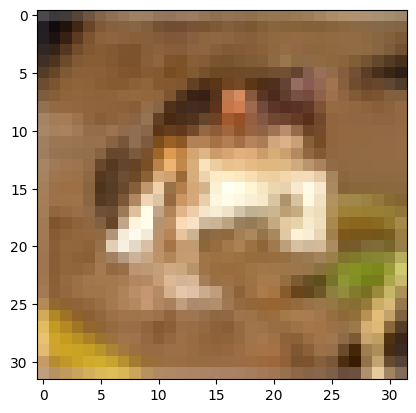

1001 [-4225.341]
1002 [-4229.216]
1003 [-4271.2695]
1004 [-4356.1206]
1005 [-4325.3433]
1006 [-4289.648]
1007 [-4259.16]
1008 [-4232.4844]
1009 [-4223.611]
1010 [-4220.3965]
1011 [-4253.504]
1012 [-4293.1143]
1013 [-4246.0693]
1014 [-4225.809]
1015 [-4206.8164]
1016 [-4224.8154]
1017 [-4214.334]
1018 [-4237.1934]
1019 [-4207.5586]
1020 [-4192.33]
1021 [-4202.8667]
1022 [-4191.3496]
1023 [-4216.6157]
1024 [-4261.9272]
1025 [-4225.1274]
1026 [-4284.513]
1027 [-4253.243]
1028 [-4247.1885]
1029 [-4251.3193]
1030 [-4207.836]
1031 [-4180.923]
1032 [-4168.416]
1033 [-4161.532]
1034 [-4199.7666]
1035 [-4275.2207]
1036 [-4205.5938]
1037 [-4174.8]
1038 [-4162.8516]
1039 [-4161.2354]
1040 [-4179.3564]
1041 [-4206.071]
1042 [-4179.094]
1043 [-4163.671]
1044 [-4163.0723]
1045 [-4156.597]
1046 [-4181.9253]
1047 [-4162.589]
1048 [-4191.7354]
1049 [-4155.9893]
1050 [-4149.4043]
1051 [-4136.423]
1052 [-4157.86]
1053 [-4220.628]
1054 [-4165.547]
1055 [-4142.757]
1056 [-4136.687]
1057 [-4155.6865]
1058 [

1100 [-4111.085]


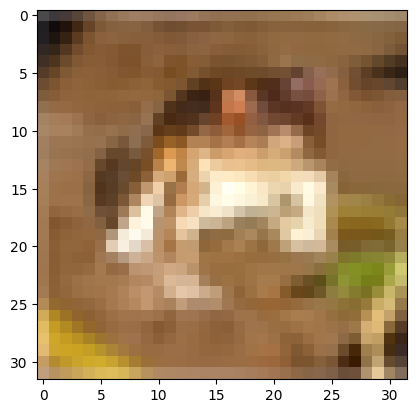

1101 [-4126.7646]
1102 [-4239.478]
1103 [-4262.327]
1104 [-4190.0005]
1105 [-4172.648]
1106 [-4130.1553]
1107 [-4114.93]
1108 [-4104.87]
1109 [-4100.97]
1110 [-4111.2637]
1111 [-4106.042]
1112 [-4077.545]
1113 [-4077.562]
1114 [-4102.712]
1115 [-4073.5159]
1116 [-4061.4993]
1117 [-4064.9229]
1118 [-4131.297]
1119 [-4202.5527]
1120 [-4165.388]
1121 [-4213.884]
1122 [-4130.3115]
1123 [-4092.6792]
1124 [-4062.7349]
1125 [-4049.774]
1126 [-4055.745]
1127 [-4199.7427]
1128 [-4137.5244]
1129 [-4207.068]
1130 [-4163.331]
1131 [-4087.53]
1132 [-4049.284]
1133 [-4032.7253]
1134 [-4078.0889]
1135 [-4162.413]
1136 [-4097.5566]
1137 [-4043.6929]
1138 [-4015.8748]
1139 [-4010.247]
1140 [-4037.8945]
1141 [-4005.6143]
1142 [-4023.2412]
1143 [-4082.1191]
1144 [-4042.8208]
1145 [-4038.755]
1146 [-4062.3494]
1147 [-4019.6914]
1148 [-4022.8354]
1149 [-4016.645]
1150 [-4049.2825]
1151 [-4006.5327]
1152 [-4012.474]
1153 [-4184.4976]
1154 [-4115.587]
1155 [-4167.175]
1156 [-4084.6853]
1157 [-4035.4805]
1158

1200 [-3925.6895]


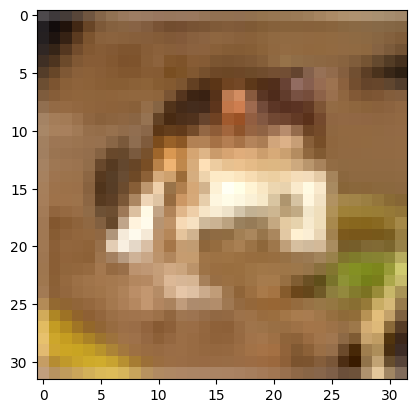

1201 [-4021.6206]
1202 [-3963.3062]
1203 [-3949.2964]
1204 [-3924.5732]
1205 [-3908.86]
1206 [-3893.858]
1207 [-3901.0415]
1208 [-3898.4348]
1209 [-3966.2004]
1210 [-3980.2295]
1211 [-3981.462]
1212 [-3926.891]
1213 [-3890.057]
1214 [-3911.2441]
1215 [-3921.537]
1216 [-3894.457]
1217 [-3911.7148]
1218 [-3875.8303]
1219 [-3849.3538]
1220 [-3856.3586]
1221 [-3869.3457]
1222 [-3840.5642]
1223 [-3846.577]
1224 [-3920.5957]
1225 [-3997.2483]
1226 [-3943.977]
1227 [-3945.2417]
1228 [-3976.3286]
1229 [-3923.4707]
1230 [-3917.2537]
1231 [-3986.076]
1232 [-3922.5664]
1233 [-3887.3965]
1234 [-3897.6763]
1235 [-3923.0771]
1236 [-3921.]
1237 [-3868.2866]
1238 [-3840.4282]
1239 [-3829.3535]
1240 [-3837.2515]
1241 [-3857.641]
1242 [-3842.7988]
1243 [-3826.4016]
1244 [-3838.2373]
1245 [-3885.0623]
1246 [-3828.425]
1247 [-3805.537]
1248 [-3873.681]
1249 [-3982.003]
1250 [-3915.4883]
1251 [-3899.3296]
1252 [-3878.97]
1253 [-3868.0515]
1254 [-3952.8767]
1255 [-3955.4595]
1256 [-3882.6924]
1257 [-3838.63

1300 [-3749.4229]


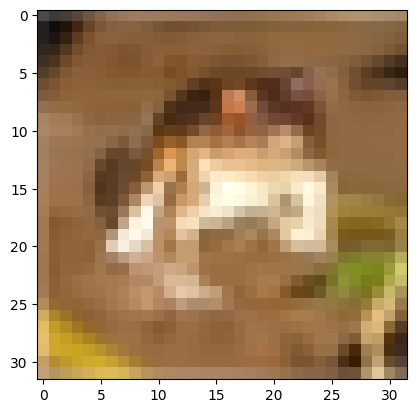

1301 [-3747.1035]
1302 [-3735.2554]
1303 [-3717.597]
1304 [-3711.706]
1305 [-3718.6274]
1306 [-3743.735]
1307 [-3722.6382]
1308 [-3720.96]
1309 [-3748.19]
1310 [-3742.4614]
1311 [-3860.1985]
1312 [-3769.753]
1313 [-3793.9126]
1314 [-3889.1885]
1315 [-3811.1218]
1316 [-3876.4214]
1317 [-3892.2603]
1318 [-3808.6929]
1319 [-3861.1133]
1320 [-3901.698]
1321 [-3792.5308]
1322 [-3760.4521]
1323 [-3749.2788]
1324 [-3718.3596]
1325 [-3702.1301]
1326 [-3722.5454]
1327 [-3785.3252]
1328 [-3725.6553]
1329 [-3701.4575]
1330 [-3713.0503]
1331 [-3730.4275]
1332 [-3738.5332]
1333 [-3687.647]
1334 [-3666.0708]
1335 [-3665.4177]
1336 [-3653.776]
1337 [-3678.5413]
1338 [-3648.6226]
1339 [-3637.7134]
1340 [-3662.6682]
1341 [-3742.296]
1342 [-3708.1367]
1343 [-3674.806]
1344 [-3828.4504]
1345 [-3796.496]
1346 [-3818.8386]
1347 [-3745.4526]
1348 [-3765.3403]
1349 [-3709.639]
1350 [-3673.3071]
1351 [-3655.5332]
1352 [-3650.425]
1353 [-3666.377]
1354 [-3711.7974]
1355 [-3668.188]
1356 [-3674.4985]
1357 [-368

1400 [-3634.928]


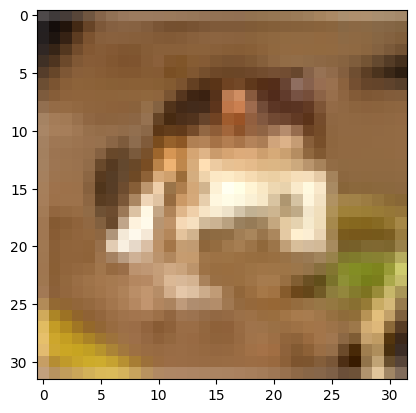

1401 [-3684.193]
1402 [-3628.663]
1403 [-3614.519]
1404 [-3626.2832]
1405 [-3607.4785]
1406 [-3584.3013]
1407 [-3578.2988]
1408 [-3578.5818]
1409 [-3583.8892]
1410 [-3567.7605]
1411 [-3564.9329]
1412 [-3675.5369]
1413 [-3782.476]
1414 [-3699.2163]
1415 [-3660.2034]
1416 [-3674.3975]
1417 [-3618.081]
1418 [-3580.3188]
1419 [-3567.5732]
1420 [-3565.0654]
1421 [-3574.4888]
1422 [-3609.7925]
1423 [-3570.1548]
1424 [-3552.2695]
1425 [-3553.253]
1426 [-3568.079]
1427 [-3592.017]
1428 [-3574.7017]
1429 [-3549.294]
1430 [-3548.641]
1431 [-3573.8003]
1432 [-3559.2854]
1433 [-3567.4536]
1434 [-3586.7441]
1435 [-3601.3418]
1436 [-3550.6382]
1437 [-3532.0059]
1438 [-3556.49]
1439 [-3587.711]
1440 [-3528.5493]
1441 [-3516.3608]
1442 [-3537.7114]
1443 [-3538.31]
1444 [-3622.5923]
1445 [-3547.5999]
1446 [-3517.1045]
1447 [-3513.94]
1448 [-3540.06]
1449 [-3637.9912]
1450 [-3600.684]
1451 [-3540.5376]
1452 [-3524.1338]
1453 [-3550.5527]
1454 [-3529.5176]
1455 [-3563.6084]
1456 [-3566.791]
1457 [-3516.4

1500 [-3486.8628]


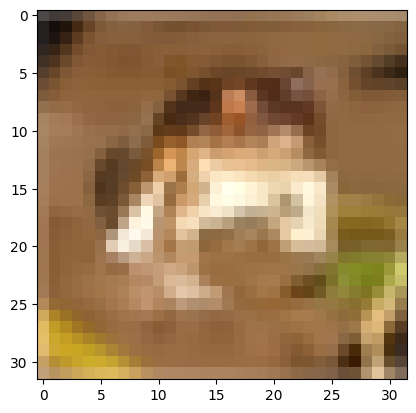

1501 [-3472.6282]
1502 [-3481.0479]
1503 [-3536.7861]
1504 [-3547.849]
1505 [-3494.0767]
1506 [-3456.9429]
1507 [-3453.126]
1508 [-3479.2202]
1509 [-3450.5767]
1510 [-3448.3293]
1511 [-3475.4985]
1512 [-3453.5493]
1513 [-3495.819]
1514 [-3543.4497]
1515 [-3481.593]
1516 [-3450.292]
1517 [-3445.4282]
1518 [-3438.6519]
1519 [-3470.4502]
1520 [-3429.3728]
1521 [-3430.0435]
1522 [-3473.5515]
1523 [-3464.425]
1524 [-3479.98]
1525 [-3445.1318]
1526 [-3430.4604]
1527 [-3443.9336]
1528 [-3426.1099]
1529 [-3439.2322]
1530 [-3418.4727]
1531 [-3432.391]
1532 [-3428.5005]
1533 [-3434.6218]
1534 [-3466.0684]
1535 [-3446.525]
1536 [-3461.49]
1537 [-3431.2366]
1538 [-3415.3994]
1539 [-3409.6152]
1540 [-3441.9426]
1541 [-3436.1965]
1542 [-3483.5693]
1543 [-3427.255]
1544 [-3404.5547]
1545 [-3418.3457]
1546 [-3398.1016]
1547 [-3404.805]
1548 [-3450.6973]
1549 [-3411.3281]
1550 [-3431.0532]
1551 [-3397.4976]
1552 [-3399.6147]
1553 [-3431.322]
1554 [-3430.2524]
1555 [-3402.064]
1556 [-3422.6045]
1557 [-3

1600 [-3348.5466]


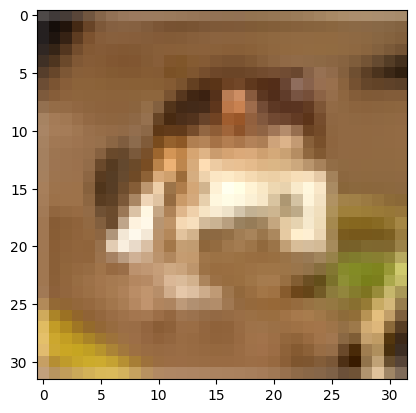

1601 [-3359.0574]
1602 [-3350.9578]
1603 [-3403.3262]
1604 [-3420.1836]
1605 [-3366.2405]
1606 [-3347.9766]
1607 [-3378.437]
1608 [-3346.7231]
1609 [-3338.5803]
1610 [-3342.6934]
1611 [-3354.311]
1612 [-3344.4092]
1613 [-3358.1448]
1614 [-3329.2363]
1615 [-3317.0806]
1616 [-3328.3774]
1617 [-3392.44]
1618 [-3373.3774]
1619 [-3371.7925]
1620 [-3586.1792]
1621 [-3497.9814]
1622 [-3554.1794]
1623 [-3469.0315]
1624 [-3421.437]
1625 [-3471.8608]
1626 [-3389.7446]
1627 [-3368.1309]
1628 [-3379.6758]
1629 [-3349.667]
1630 [-3340.0566]
1631 [-3336.2002]
1632 [-3344.0688]
1633 [-3383.585]
1634 [-3351.631]
1635 [-3338.435]
1636 [-3355.2456]
1637 [-3342.5327]
1638 [-3342.514]
1639 [-3342.5986]
1640 [-3384.4744]
1641 [-3363.6138]
1642 [-3327.7776]
1643 [-3315.582]
1644 [-3318.0063]
1645 [-3341.7773]
1646 [-3330.586]
1647 [-3374.5269]
1648 [-3327.7446]
1649 [-3313.4893]
1650 [-3319.0078]
1651 [-3378.296]
1652 [-3335.521]
1653 [-3313.3506]
1654 [-3303.359]
1655 [-3308.5647]
1656 [-3322.4658]
1657 [-

1700 [-3283.6309]


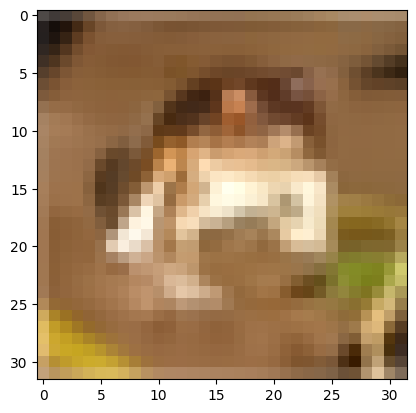

1701 [-3273.771]
1702 [-3267.5437]
1703 [-3285.727]
1704 [-3276.2334]
1705 [-3290.3938]
1706 [-3255.346]
1707 [-3245.816]
1708 [-3265.3423]
1709 [-3313.0432]
1710 [-3273.2124]
1711 [-3245.8892]
1712 [-3254.2288]
1713 [-3326.0647]
1714 [-3294.0085]
1715 [-3312.5623]
1716 [-3272.253]
1717 [-3299.9375]
1718 [-3285.1914]
1719 [-3245.911]
1720 [-3237.9238]
1721 [-3235.2627]
1722 [-3261.7686]
1723 [-3293.0237]
1724 [-3260.168]
1725 [-3258.996]
1726 [-3281.7388]
1727 [-3257.0105]
1728 [-3257.579]
1729 [-3232.2915]
1730 [-3225.771]
1731 [-3229.3787]
1732 [-3255.4692]
1733 [-3227.3145]
1734 [-3217.536]
1735 [-3223.9263]
1736 [-3248.2734]
1737 [-3318.6968]
1738 [-3283.9526]
1739 [-3249.6973]
1740 [-3266.4768]
1741 [-3353.1292]
1742 [-3297.3784]
1743 [-3285.6401]
1744 [-3367.5308]
1745 [-3278.75]
1746 [-3266.8525]
1747 [-3239.3726]
1748 [-3225.645]
1749 [-3249.9204]
1750 [-3231.0085]
1751 [-3271.8755]
1752 [-3252.5771]
1753 [-3218.6692]
1754 [-3225.6992]
1755 [-3233.1533]
1756 [-3287.6936]
1757 [

1800 [-3161.668]


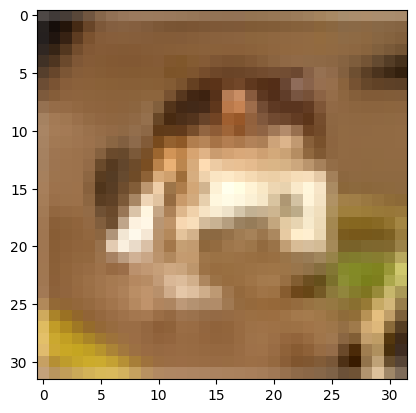

1801 [-3164.5747]
1802 [-3221.4133]
1803 [-3213.2402]
1804 [-3225.3965]
1805 [-3221.8193]
1806 [-3292.0735]
1807 [-3248.9863]
1808 [-3241.8286]
1809 [-3166.4956]
1810 [-3164.5266]
1811 [-3205.1763]
1812 [-3177.1926]
1813 [-3164.4019]
1814 [-3151.9165]
1815 [-3157.51]
1816 [-3223.1992]
1817 [-3209.901]
1818 [-3171.465]
1819 [-3205.3872]
1820 [-3156.2158]
1821 [-3149.5903]
1822 [-3172.744]
1823 [-3149.9321]
1824 [-3142.2476]
1825 [-3166.437]
1826 [-3255.9165]
1827 [-3181.1646]
1828 [-3155.621]
1829 [-3148.1855]
1830 [-3180.7856]
1831 [-3155.0427]
1832 [-3140.8672]
1833 [-3151.959]
1834 [-3154.1582]
1835 [-3138.003]
1836 [-3194.8457]
1837 [-3158.505]
1838 [-3139.14]
1839 [-3128.1653]
1840 [-3134.8105]
1841 [-3213.5366]
1842 [-3149.391]
1843 [-3153.3474]
1844 [-3236.2632]
1845 [-3202.7856]
1846 [-3170.6187]
1847 [-3152.513]
1848 [-3140.7395]
1849 [-3131.008]
1850 [-3169.8853]
1851 [-3206.4604]
1852 [-3137.135]
1853 [-3132.236]
1854 [-3214.487]
1855 [-3144.5718]
1856 [-3120.231]
1857 [-3121

1900 [-3068.7612]


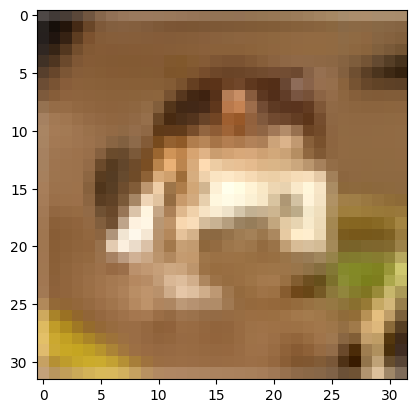

1901 [-3093.1838]
1902 [-3086.897]
1903 [-3115.565]
1904 [-3112.8745]
1905 [-3130.4377]
1906 [-3136.1782]
1907 [-3079.1338]
1908 [-3077.0635]
1909 [-3138.3977]
1910 [-3085.3408]
1911 [-3065.0693]
1912 [-3081.2622]
1913 [-3063.1895]
1914 [-3120.4844]
1915 [-3068.4487]
1916 [-3059.2913]
1917 [-3054.5693]
1918 [-3055.4988]
1919 [-3087.4084]
1920 [-3050.6714]
1921 [-3045.0386]
1922 [-3079.503]
1923 [-3054.6235]
1924 [-3087.389]
1925 [-3163.7007]
1926 [-3104.018]
1927 [-3098.4966]
1928 [-3047.2334]
1929 [-3034.7046]
1930 [-3078.1833]
1931 [-3163.1729]
1932 [-3090.4058]
1933 [-3104.7026]
1934 [-3233.5684]
1935 [-3127.9966]
1936 [-3079.0781]
1937 [-3112.6938]
1938 [-3123.4497]
1939 [-3075.1343]
1940 [-3055.5005]
1941 [-3053.115]
1942 [-3034.6287]
1943 [-3028.052]
1944 [-3079.5625]
1945 [-3081.0562]
1946 [-3037.7617]
1947 [-3035.8728]
1948 [-3063.713]
1949 [-3026.4204]
1950 [-3017.458]
1951 [-3016.1484]
1952 [-3053.6572]
1953 [-3017.8262]
1954 [-3049.474]
1955 [-3008.0325]
1956 [-3038.839]
195

2000 [-3004.1323]


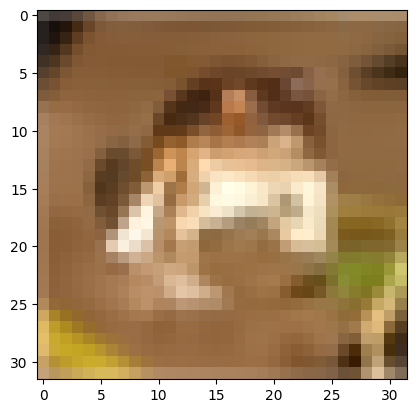

2001 [-2995.4363]
2002 [-2991.9702]
2003 [-2993.3171]
2004 [-2994.0298]
2005 [-3001.174]
2006 [-3007.4165]
2007 [-3010.5005]
2008 [-2979.061]
2009 [-2991.7778]
2010 [-2994.3071]
2011 [-2985.1323]
2012 [-3008.105]
2013 [-2972.706]
2014 [-2967.1655]
2015 [-2975.206]
2016 [-3011.9526]
2017 [-2961.4795]
2018 [-2958.224]
2019 [-2963.2993]
2020 [-3007.6943]
2021 [-2960.8188]
2022 [-2955.392]
2023 [-2949.6387]
2024 [-2957.1384]
2025 [-2972.6243]
2026 [-3098.0605]
2027 [-3031.9807]
2028 [-3050.0308]
2029 [-2992.0605]
2030 [-2972.516]
2031 [-2970.9111]
2032 [-3028.616]
2033 [-2975.0098]
2034 [-2986.4744]
2035 [-2960.8071]
2036 [-2985.8281]
2037 [-2949.6475]
2038 [-2949.5361]
2039 [-2955.4448]
2040 [-2993.0283]
2041 [-2945.4521]
2042 [-2942.5237]
2043 [-2969.243]
2044 [-2950.376]
2045 [-2989.9885]
2046 [-2950.4307]
2047 [-2944.1084]
2048 [-2945.559]
2049 [-2954.0571]
2050 [-2994.766]
2051 [-2953.6226]
2052 [-2969.0278]
2053 [-2960.8843]
2054 [-2961.857]
2055 [-2943.4163]
2056 [-2937.807]
2057 [-

2100 [-2908.609]


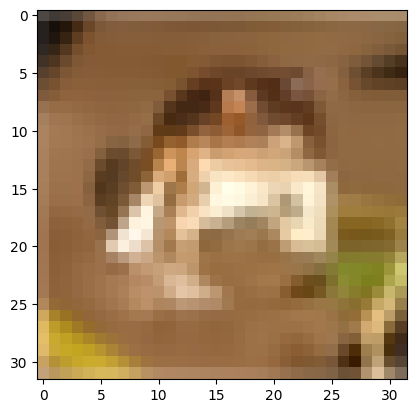

2101 [-2901.217]
2102 [-2965.8013]
2103 [-3139.7915]
2104 [-3075.9817]
2105 [-2999.879]
2106 [-2950.5952]
2107 [-2934.1458]
2108 [-2926.8145]
2109 [-2907.7012]
2110 [-2914.7896]
2111 [-3004.856]
2112 [-2940.7314]
2113 [-2912.0286]
2114 [-2902.208]
2115 [-2903.0256]
2116 [-2904.728]
2117 [-2952.2148]
2118 [-2923.831]
2119 [-2949.2083]
2120 [-2918.1912]
2121 [-2908.18]
2122 [-2950.5518]
2123 [-3024.9248]
2124 [-3349.3662]
2125 [-3261.5718]
2126 [-3199.976]
2127 [-3154.9885]
2128 [-3125.4922]
2129 [-3104.1377]
2130 [-3058.3726]
2131 [-3022.6628]
2132 [-2998.0278]
2133 [-2985.2256]
2134 [-2963.7158]
2135 [-2968.8545]
2136 [-2931.7744]
2137 [-2928.369]
2138 [-2924.9292]
2139 [-3026.567]
2140 [-3008.229]
2141 [-2946.1538]
2142 [-2982.94]
2143 [-2931.6519]
2144 [-2903.4834]
2145 [-2894.6775]
2146 [-2909.6729]
2147 [-2935.9204]
2148 [-2904.8745]
2149 [-2883.3315]
2150 [-2898.2998]
2151 [-2879.77]
2152 [-2913.4307]
2153 [-2877.3389]
2154 [-2868.3525]
2155 [-2865.895]
2156 [-2932.2014]
2157 [-28

2200 [-2845.1475]


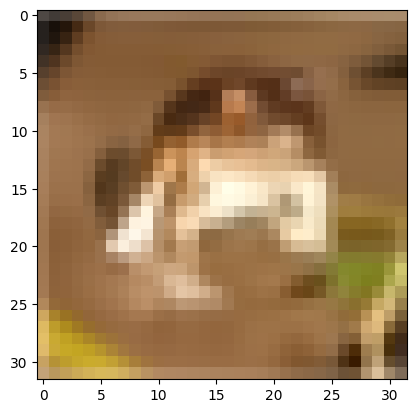

2201 [-2852.8872]
2202 [-2869.9106]
2203 [-2889.3196]
2204 [-2864.688]
2205 [-2861.3877]
2206 [-2865.5327]
2207 [-2862.5918]
2208 [-2880.583]
2209 [-2869.9478]
2210 [-2843.6868]
2211 [-2895.7937]
2212 [-2896.3142]
2213 [-2969.506]
2214 [-3275.1628]
2215 [-3108.0146]
2216 [-3047.5283]
2217 [-2979.0889]
2218 [-2939.7935]
2219 [-2926.1333]
2220 [-2900.08]
2221 [-2884.3057]
2222 [-2879.475]
2223 [-2868.3367]
2224 [-2867.605]
2225 [-2856.8713]
2226 [-2885.7534]
2227 [-2900.109]
2228 [-2859.1594]
2229 [-2875.7744]
2230 [-2865.058]
2231 [-2839.6943]
2232 [-2841.3782]
2233 [-2860.3455]
2234 [-2861.2964]
2235 [-2843.4858]
2236 [-2842.6743]
2237 [-2893.5752]
2238 [-2885.2793]
2239 [-2836.977]
2240 [-2834.1785]
2241 [-2882.9785]
2242 [-2910.393]
2243 [-2897.1907]
2244 [-2841.5464]
2245 [-2823.8062]
2246 [-2826.243]
2247 [-2840.7983]
2248 [-2848.8364]
2249 [-2861.8154]
2250 [-2815.745]
2251 [-2823.6616]
2252 [-2825.7832]
2253 [-2825.8008]
2254 [-2833.5415]
2255 [-2888.0933]
2256 [-2859.6846]
2257 

2300 [-2882.4912]


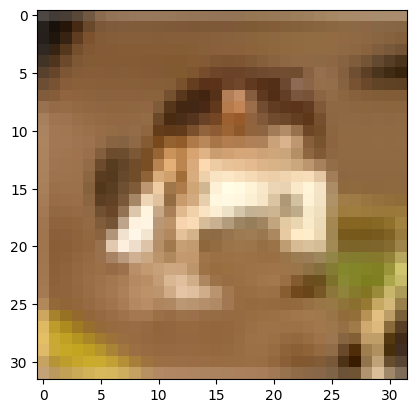

2301 [-2860.0498]
2302 [-2861.2246]
2303 [-2826.082]
2304 [-2817.6958]
2305 [-2780.1855]
2306 [-2771.5305]
2307 [-2766.01]
2308 [-2801.8284]
2309 [-2791.2446]
2310 [-2811.005]
2311 [-2774.812]
2312 [-2769.5127]
2313 [-2755.789]
2314 [-2775.3901]
2315 [-2785.7666]
2316 [-2799.8745]
2317 [-2768.3406]
2318 [-2757.587]
2319 [-2765.748]
2320 [-2789.1274]
2321 [-2768.1401]
2322 [-2777.5156]
2323 [-2764.0024]
2324 [-2755.3032]
2325 [-2748.3582]
2326 [-2754.0828]
2327 [-2738.8457]
2328 [-2746.5903]
2329 [-2740.7031]
2330 [-2745.8823]
2331 [-2745.4368]
2332 [-2760.579]
2333 [-2750.9207]
2334 [-2793.0945]
2335 [-2771.4368]
2336 [-2749.4915]
2337 [-2732.894]
2338 [-2737.3247]
2339 [-2742.144]
2340 [-2777.0098]
2341 [-2787.5862]
2342 [-2777.1843]
2343 [-2743.52]
2344 [-2735.4194]
2345 [-2734.1814]
2346 [-2743.1626]
2347 [-2734.6565]
2348 [-2739.6655]
2349 [-2738.075]
2350 [-2747.1392]
2351 [-2833.7256]
2352 [-2814.607]
2353 [-2814.4578]
2354 [-2767.1492]
2355 [-2744.2622]
2356 [-2740.635]
2357 [-2

2400 [-2697.1729]


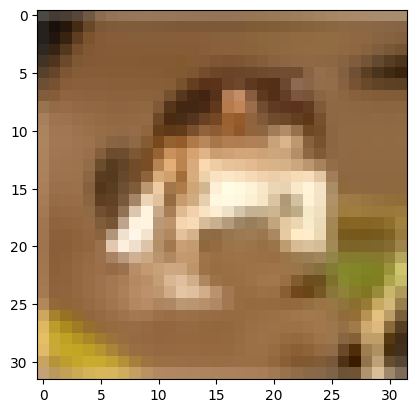

2401 [-2685.512]
2402 [-2696.3071]
2403 [-2698.4526]
2404 [-2691.501]
2405 [-2685.6921]
2406 [-2696.0364]
2407 [-2732.6182]
2408 [-2699.9534]
2409 [-2696.1377]
2410 [-2696.272]
2411 [-2732.017]
2412 [-2743.331]
2413 [-2773.2097]
2414 [-2732.8435]
2415 [-2734.6365]
2416 [-2718.0928]
2417 [-2773.4663]
2418 [-2717.1648]
2419 [-2705.563]
2420 [-2685.3413]
2421 [-2696.0615]
2422 [-2695.0015]
2423 [-2696.9993]
2424 [-2681.9229]
2425 [-2678.1094]
2426 [-2668.9756]
2427 [-2683.834]
2428 [-2704.3489]
2429 [-2838.2617]
2430 [-2933.3164]
2431 [-2935.0479]
2432 [-2817.6433]
2433 [-2808.5107]
2434 [-2793.4292]
2435 [-2746.4185]
2436 [-2738.7625]
2437 [-2729.1807]
2438 [-2711.2646]
2439 [-2690.7866]
2440 [-2684.6724]
2441 [-2683.5962]
2442 [-2690.816]
2443 [-2723.147]
2444 [-2697.6816]
2445 [-2724.747]
2446 [-2700.3145]
2447 [-2698.0342]
2448 [-2701.255]
2449 [-2711.0894]
2450 [-2686.5852]
2451 [-2719.8528]
2452 [-2720.9893]
2453 [-2764.1523]
2454 [-2707.6802]
2455 [-2686.9507]
2456 [-2700.7751]
245

2500 [-2717.4966]


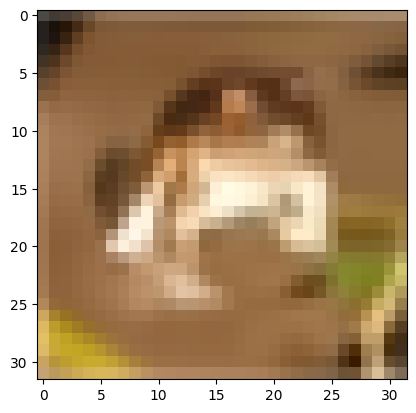

2501 [-2737.4905]
2502 [-2696.6787]
2503 [-2706.229]
2504 [-2857.6758]
2505 [-2912.0042]
2506 [-2875.208]
2507 [-2831.5999]
2508 [-2787.7046]
2509 [-2746.6648]
2510 [-2734.5605]
2511 [-2723.077]
2512 [-2724.2698]
2513 [-2675.0522]
2514 [-2697.5881]
2515 [-2663.3784]
2516 [-2653.0146]
2517 [-2652.1758]
2518 [-2674.8296]
2519 [-2713.6543]
2520 [-2791.1733]
2521 [-2724.193]
2522 [-2708.6118]
2523 [-2694.336]
2524 [-2686.8848]
2525 [-2699.8083]
2526 [-2677.3481]
2527 [-2643.2734]
2528 [-2645.7305]
2529 [-2676.9602]
2530 [-2672.9736]
2531 [-2661.102]
2532 [-2645.564]
2533 [-2625.4888]
2534 [-2637.5012]
2535 [-2651.0508]
2536 [-2651.6284]
2537 [-2637.239]
2538 [-2721.2388]
2539 [-2682.6611]
2540 [-2692.644]
2541 [-2675.4329]
2542 [-2647.2998]
2543 [-2625.54]
2544 [-2618.1309]
2545 [-2629.7568]
2546 [-2648.2441]
2547 [-2625.6262]
2548 [-2606.2275]
2549 [-2603.1523]
2550 [-2607.0974]
2551 [-2638.1284]
2552 [-2674.5464]
2553 [-2634.1958]
2554 [-2648.7202]
2555 [-2672.066]
2556 [-2649.664]
2557 

2600 [-2614.8452]


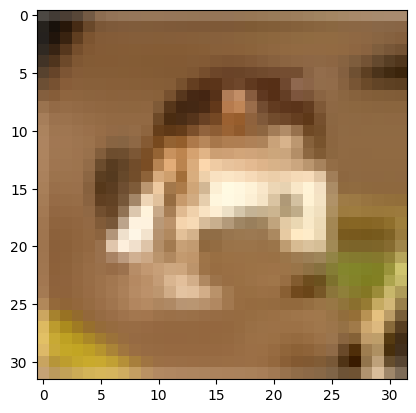

2601 [-2601.7283]
2602 [-2665.129]
2603 [-2654.0142]
2604 [-2736.0142]
2605 [-2657.9258]
2606 [-2627.9663]
2607 [-2613.8494]
2608 [-2618.7766]
2609 [-2628.4783]
2610 [-2604.0078]
2611 [-2598.7349]
2612 [-2603.6194]
2613 [-2616.6245]
2614 [-2603.7266]
2615 [-2640.75]
2616 [-2656.1567]
2617 [-3005.9531]
2618 [-2871.5686]
2619 [-2813.6414]
2620 [-2822.6362]
2621 [-2756.2646]
2622 [-2718.8618]
2623 [-2708.7922]
2624 [-2766.7827]
2625 [-2732.2334]
2626 [-2696.255]
2627 [-2668.065]
2628 [-2683.3857]
2629 [-2649.8828]
2630 [-2619.3955]
2631 [-2604.5469]
2632 [-2609.0137]
2633 [-2598.315]
2634 [-2647.6633]
2635 [-2619.7937]
2636 [-2627.3096]
2637 [-2593.7551]
2638 [-2590.4082]
2639 [-2611.3857]
2640 [-2612.3416]
2641 [-2620.4668]
2642 [-2590.246]
2643 [-2583.8203]
2644 [-2578.4922]
2645 [-2585.28]
2646 [-2592.9883]
2647 [-2629.671]
2648 [-2611.023]
2649 [-2594.3076]
2650 [-2610.1802]
2651 [-2615.3252]
2652 [-2587.8345]
2653 [-2597.5571]
2654 [-2594.309]
2655 [-2570.1533]
2656 [-2557.8062]
2657

2700 [-2567.2139]


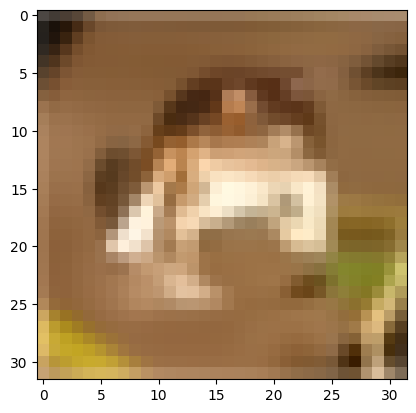

2701 [-2612.4355]
2702 [-2578.2527]
2703 [-2562.6753]
2704 [-2545.583]
2705 [-2542.3696]
2706 [-2567.712]
2707 [-2537.3145]
2708 [-2537.0342]
2709 [-2530.898]
2710 [-2536.2993]
2711 [-2545.867]
2712 [-2530.4856]
2713 [-2526.5073]
2714 [-2533.9763]
2715 [-2545.7437]
2716 [-2553.1392]
2717 [-2709.7266]
2718 [-2744.269]
2719 [-2678.0474]
2720 [-2623.9597]
2721 [-2636.4766]
2722 [-2651.141]
2723 [-2824.2769]
2724 [-2707.955]
2725 [-2691.3794]
2726 [-2726.2483]
2727 [-2685.499]
2728 [-2651.9155]
2729 [-2634.6763]
2730 [-2607.2732]
2731 [-2638.535]
2732 [-2634.1997]
2733 [-2602.6926]
2734 [-2564.101]
2735 [-2547.0193]
2736 [-2529.9536]
2737 [-2528.6846]
2738 [-2531.7527]
2739 [-2552.0918]
2740 [-2590.1516]
2741 [-2564.1719]
2742 [-2534.4277]
2743 [-2534.2573]
2744 [-2592.4062]
2745 [-2561.3423]
2746 [-2549.5386]
2747 [-2530.1396]
2748 [-2522.378]
2749 [-2551.162]
2750 [-2648.9739]
2751 [-2743.9675]
2752 [-2684.9277]
2753 [-2688.2974]
2754 [-2620.796]
2755 [-2600.7153]
2756 [-2579.5637]
2757 

2800 [-2562.284]


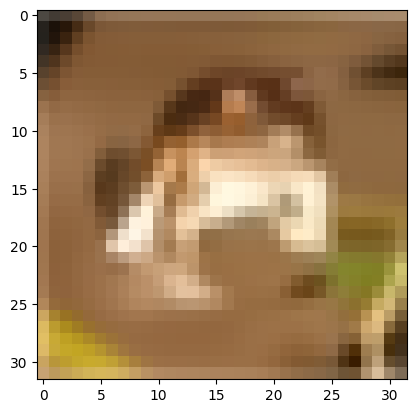

2801 [-2513.9678]
2802 [-2493.9917]
2803 [-2488.5903]
2804 [-2489.7468]
2805 [-2479.9648]
2806 [-2486.6885]
2807 [-2482.7139]
2808 [-2558.5635]
2809 [-2605.896]
2810 [-2549.3538]
2811 [-2519.0479]
2812 [-2502.6055]
2813 [-2497.3271]
2814 [-2508.1943]
2815 [-2491.2046]
2816 [-2490.3262]
2817 [-2492.3728]
2818 [-2497.1025]
2819 [-2519.938]
2820 [-2515.899]
2821 [-2604.3074]
2822 [-2535.879]
2823 [-2502.229]
2824 [-2495.5808]
2825 [-2502.009]
2826 [-2497.7751]
2827 [-2554.4976]
2828 [-2528.8696]
2829 [-2540.3188]
2830 [-2543.3367]
2831 [-2504.5518]
2832 [-2491.4316]
2833 [-2482.3354]
2834 [-2474.7798]
2835 [-2475.38]
2836 [-2478.311]
2837 [-2484.6128]
2838 [-2506.1218]
2839 [-2541.025]
2840 [-2567.0479]
2841 [-2554.455]
2842 [-2521.4683]
2843 [-2504.9592]
2844 [-2496.2234]
2845 [-2514.9663]
2846 [-2494.871]
2847 [-2477.9883]
2848 [-2467.2065]
2849 [-2468.2588]
2850 [-2480.1938]
2851 [-2478.9453]
2852 [-2477.3672]
2853 [-2464.9644]
2854 [-2469.4287]
2855 [-2475.4978]
2856 [-2464.4373]
2857

2900 [-2455.65]


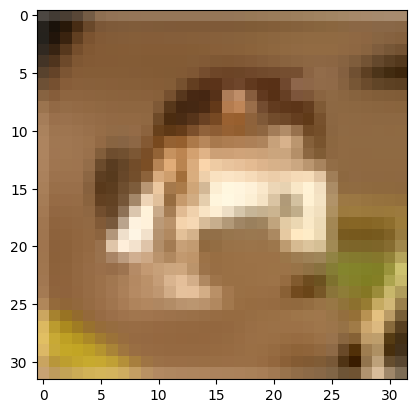

2901 [-2463.5032]
2902 [-2451.9219]
2903 [-2449.6301]
2904 [-2445.4426]
2905 [-2455.131]
2906 [-2454.816]
2907 [-2482.7173]
2908 [-2701.2039]
2909 [-2763.476]
2910 [-2631.1963]
2911 [-2572.605]
2912 [-2564.9646]
2913 [-2560.7944]
2914 [-2567.2495]
2915 [-2588.4292]
2916 [-2517.5264]
2917 [-2480.3076]
2918 [-2465.6729]
2919 [-2464.8354]
2920 [-2510.6736]
2921 [-2513.7085]
2922 [-2604.5264]
2923 [-2547.2495]
2924 [-2560.2407]
2925 [-2502.201]
2926 [-2501.4287]
2927 [-2477.7485]
2928 [-2455.4292]
2929 [-2462.27]
2930 [-2459.7603]
2931 [-2466.238]
2932 [-2447.9019]
2933 [-2441.078]
2934 [-2440.1812]
2935 [-2447.3687]
2936 [-2448.81]
2937 [-2522.2188]
2938 [-2524.256]
2939 [-2493.1846]
2940 [-2476.7322]
2941 [-2448.7788]
2942 [-2447.308]
2943 [-2454.811]
2944 [-2466.0022]
2945 [-2466.7827]
2946 [-2468.9067]
2947 [-2454.3552]
2948 [-2456.7083]
2949 [-2456.4316]
2950 [-2445.011]
2951 [-2424.8723]
2952 [-2440.7744]
2953 [-2448.2092]
2954 [-2442.1138]
2955 [-2458.419]
2956 [-2457.3696]
2957 [-2

3000 [-2458.356]


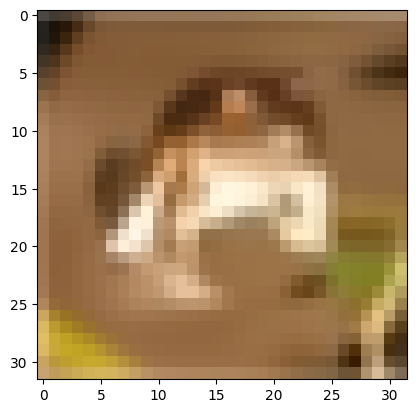

3001 [-2453.5618]
3002 [-2430.9614]
3003 [-2430.378]
3004 [-2465.1968]
3005 [-2437.0515]
3006 [-2462.2717]
3007 [-2443.5723]
3008 [-2420.1323]
3009 [-2415.942]
3010 [-2407.8545]
3011 [-2403.3774]
3012 [-2410.7744]
3013 [-2403.937]
3014 [-2416.5996]
3015 [-2402.0947]
3016 [-2411.4333]
3017 [-2403.7417]
3018 [-2392.4062]
3019 [-2395.188]
3020 [-2430.1367]
3021 [-2459.7925]
3022 [-2485.3955]
3023 [-2453.4417]
3024 [-2466.505]
3025 [-2487.0796]
3026 [-2503.4165]
3027 [-2505.0645]
3028 [-2485.309]
3029 [-2483.0796]
3030 [-2446.3438]
3031 [-2425.608]
3032 [-2423.86]
3033 [-2407.1997]
3034 [-2402.5654]
3035 [-2404.0044]
3036 [-2400.902]
3037 [-2409.5623]
3038 [-2418.7917]
3039 [-2473.4104]
3040 [-2444.5835]
3041 [-2440.7715]
3042 [-2447.0159]
3043 [-2438.401]
3044 [-2430.1536]
3045 [-2401.0667]
3046 [-2389.41]
3047 [-2390.206]
3048 [-2396.609]
3049 [-2392.7344]
3050 [-2421.8896]
3051 [-2404.9736]
3052 [-2475.2305]
3053 [-2448.8423]
3054 [-2419.4949]
3055 [-2423.5906]
3056 [-2433.5713]
3057 [-

3100 [-2368.8748]


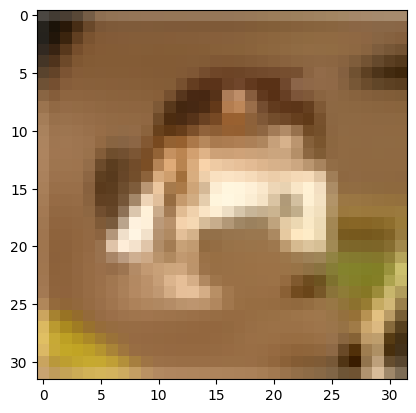

3101 [-2369.6558]
3102 [-2410.0361]
3103 [-2424.0662]
3104 [-2407.112]
3105 [-2496.3738]
3106 [-2474.9207]
3107 [-2430.6016]
3108 [-2423.411]
3109 [-2426.7822]
3110 [-2395.35]
3111 [-2379.815]
3112 [-2379.2249]
3113 [-2379.0706]
3114 [-2382.5078]
3115 [-2366.2915]
3116 [-2369.4868]
3117 [-2365.687]
3118 [-2371.2708]
3119 [-2366.35]
3120 [-2375.9995]
3121 [-2362.4243]
3122 [-2366.283]
3123 [-2364.792]
3124 [-2374.6475]
3125 [-2392.1523]
3126 [-2400.8333]
3127 [-2392.6858]
3128 [-2377.555]
3129 [-2382.0117]
3130 [-2364.8323]
3131 [-2376.12]
3132 [-2363.7004]
3133 [-2362.4658]
3134 [-2353.0317]
3135 [-2358.3096]
3136 [-2358.1665]
3137 [-2366.567]
3138 [-2366.8054]
3139 [-2378.2717]
3140 [-2367.8242]
3141 [-2382.476]
3142 [-2389.093]
3143 [-2375.2935]
3144 [-2373.025]
3145 [-2382.898]
3146 [-2369.285]
3147 [-2356.344]
3148 [-2356.602]
3149 [-2352.91]
3150 [-2357.9932]
3151 [-2358.3025]
3152 [-2361.1953]
3153 [-2355.8438]
3154 [-2363.7908]
3155 [-2355.1245]
3156 [-2349.6738]
3157 [-2350.414

3200 [-2386.2686]


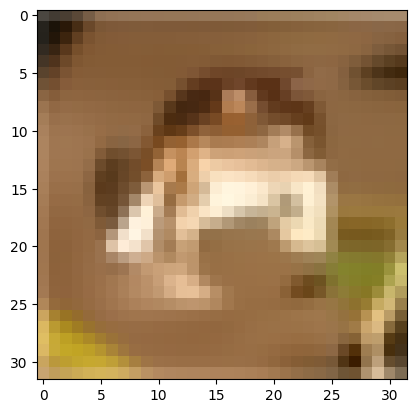

3201 [-2356.9365]
3202 [-2449.2617]
3203 [-2558.5178]
3204 [-2517.8145]
3205 [-2459.332]
3206 [-2416.4893]
3207 [-2405.9111]
3208 [-2435.8643]
3209 [-2435.086]
3210 [-2401.7456]
3211 [-2371.8901]
3212 [-2378.3154]
3213 [-2371.0215]
3214 [-2374.393]
3215 [-2353.9275]
3216 [-2356.3513]
3217 [-2348.344]
3218 [-2355.2341]
3219 [-2373.6338]
3220 [-2347.7556]
3221 [-2358.7727]
3222 [-2352.5273]
3223 [-2344.2646]
3224 [-2348.63]
3225 [-2370.6267]
3226 [-2355.2988]
3227 [-2352.7876]
3228 [-2355.8455]
3229 [-2356.2725]
3230 [-2345.6199]
3231 [-2347.3535]
3232 [-2352.612]
3233 [-2367.2866]
3234 [-2372.7388]
3235 [-2431.8818]
3236 [-2485.2969]
3237 [-2464.792]
3238 [-2458.1108]
3239 [-2433.5051]
3240 [-2404.6797]
3241 [-2391.7185]
3242 [-2369.7783]
3243 [-2362.5972]
3244 [-2376.499]
3245 [-2399.3464]
3246 [-2381.7717]
3247 [-2353.6284]
3248 [-2352.7039]
3249 [-2377.2407]
3250 [-2371.1257]
3251 [-2388.797]
3252 [-2391.5593]
3253 [-2368.785]
3254 [-2354.4495]
3255 [-2348.774]
3256 [-2331.6772]
3257

3300 [-2364.271]


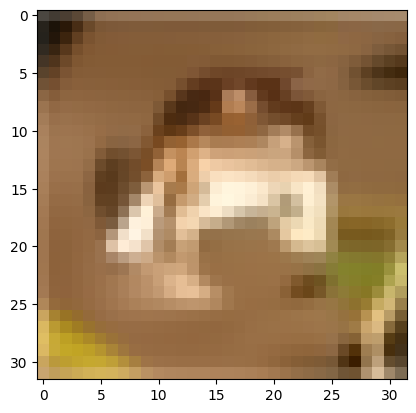

3301 [-2458.9937]
3302 [-2390.5703]
3303 [-2363.6958]
3304 [-2385.7344]
3305 [-2366.589]
3306 [-2339.4443]
3307 [-2357.2366]
3308 [-2394.1702]
3309 [-2422.3657]
3310 [-2448.332]
3311 [-2408.3535]
3312 [-2368.8062]
3313 [-2377.367]
3314 [-2347.8125]
3315 [-2358.2456]
3316 [-2326.3982]
3317 [-2320.2646]
3318 [-2334.5327]
3319 [-2337.7534]
3320 [-2323.4233]
3321 [-2314.1587]
3322 [-2317.6484]
3323 [-2354.2573]
3324 [-2350.392]
3325 [-2333.5686]
3326 [-2325.5413]
3327 [-2307.5562]
3328 [-2296.7786]
3329 [-2303.7998]
3330 [-2295.2036]
3331 [-2311.1309]
3332 [-2323.5625]
3333 [-2314.7532]
3334 [-2348.6655]
3335 [-2326.421]
3336 [-2320.2703]
3337 [-2323.699]
3338 [-2297.5706]
3339 [-2295.42]
3340 [-2293.8418]
3341 [-2318.553]
3342 [-2332.4067]
3343 [-2318.978]
3344 [-2306.0498]
3345 [-2296.4722]
3346 [-2288.161]
3347 [-2286.707]
3348 [-2290.3066]
3349 [-2305.715]
3350 [-2309.3098]
3351 [-2353.5464]
3352 [-2505.9458]
3353 [-2659.3438]
3354 [-2592.7734]
3355 [-2548.5815]
3356 [-2481.1958]
3357 

3400 [-2324.7847]


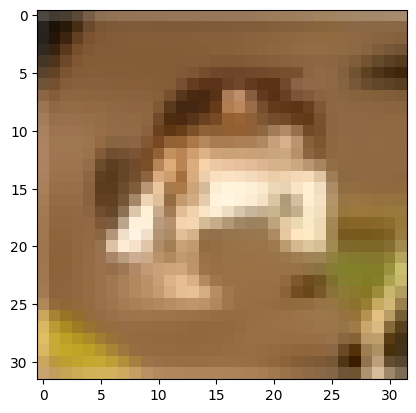

3401 [-2321.4019]
3402 [-2310.716]
3403 [-2317.9854]
3404 [-2298.734]
3405 [-2297.6172]
3406 [-2300.6953]
3407 [-2345.0662]
3408 [-2306.8384]
3409 [-2306.196]
3410 [-2310.9146]
3411 [-2332.2002]
3412 [-2309.9868]
3413 [-2315.8325]
3414 [-2312.684]
3415 [-2296.3765]
3416 [-2288.6997]
3417 [-2310.9795]
3418 [-2296.4785]
3419 [-2287.2485]
3420 [-2294.11]
3421 [-2354.546]
3422 [-2331.7385]
3423 [-2471.2812]
3424 [-2423.0488]
3425 [-2573.5874]
3426 [-2529.8823]
3427 [-2447.6135]
3428 [-2402.77]
3429 [-2405.7432]
3430 [-2373.6033]
3431 [-2371.7156]
3432 [-2353.876]
3433 [-2323.2434]
3434 [-2312.6023]
3435 [-2300.9478]
3436 [-2286.7808]
3437 [-2283.9575]
3438 [-2282.7812]
3439 [-2292.7944]
3440 [-2282.2788]
3441 [-2293.1475]
3442 [-2280.2656]
3443 [-2307.003]
3444 [-2288.9849]
3445 [-2284.5303]
3446 [-2272.7983]
3447 [-2272.4902]
3448 [-2259.6538]
3449 [-2270.6152]
3450 [-2259.5303]
3451 [-2265.425]
3452 [-2261.0425]
3453 [-2283.1152]
3454 [-2262.7463]
3455 [-2259.4663]
3456 [-2255.2764]
3457

3500 [-2260.878]


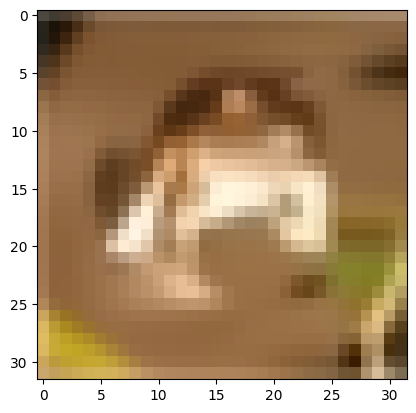

3501 [-2251.886]
3502 [-2253.7317]
3503 [-2260.1655]
3504 [-2238.1907]
3505 [-2246.017]
3506 [-2236.2397]
3507 [-2239.402]
3508 [-2235.38]
3509 [-2248.3508]
3510 [-2273.2227]
3511 [-2263.9634]
3512 [-2259.9902]
3513 [-2260.1453]
3514 [-2302.6028]
3515 [-2323.2822]
3516 [-2284.1147]
3517 [-2254.6428]
3518 [-2247.963]
3519 [-2258.5178]
3520 [-2234.8564]
3521 [-2239.9512]
3522 [-2234.454]
3523 [-2228.636]
3524 [-2226.2178]
3525 [-2230.1877]
3526 [-2246.0132]
3527 [-2260.508]
3528 [-2255.6536]
3529 [-2249.8748]
3530 [-2245.7158]
3531 [-2292.457]
3532 [-2304.4556]
3533 [-2297.083]
3534 [-2299.878]
3535 [-2336.5554]
3536 [-2293.2715]
3537 [-2319.7144]
3538 [-2276.414]
3539 [-2243.9658]
3540 [-2230.8298]
3541 [-2232.446]
3542 [-2227.5264]
3543 [-2233.8008]
3544 [-2240.9268]
3545 [-2230.3735]
3546 [-2226.7002]
3547 [-2221.3499]
3548 [-2229.9463]
3549 [-2244.3525]
3550 [-2227.4875]
3551 [-2236.6465]
3552 [-2318.9204]
3553 [-2271.6301]
3554 [-2241.1663]
3555 [-2244.8086]
3556 [-2250.0894]
3557 [

3600 [-2232.295]


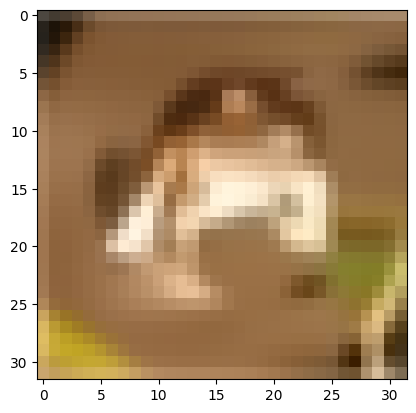

3601 [-2247.898]
3602 [-2276.7007]
3603 [-2298.875]
3604 [-2439.7183]
3605 [-2590.2097]
3606 [-2456.6694]
3607 [-2451.666]
3608 [-2377.2896]
3609 [-2334.9954]
3610 [-2317.3896]
3611 [-2300.5886]
3612 [-2320.8672]
3613 [-2360.0093]
3614 [-2355.1685]
3615 [-2358.3076]
3616 [-2477.4944]
3617 [-2337.8286]
3618 [-2292.4492]
3619 [-2279.9465]
3620 [-2289.4016]
3621 [-2291.0737]
3622 [-2280.7114]
3623 [-2258.4617]
3624 [-2241.2812]
3625 [-2234.0151]
3626 [-2230.5732]


KeyboardInterrupt: 

In [35]:
# SUBIMOS LA PROBABILIDAD EN BUCLE
#SIGS = np.logspace(-10,0,500)

salto = 0.000001

Nsteps = 5000
#RR = np.zeros(SIGS.shape)
pS = np.zeros(Nsteps)

X_limpiada = x_np_noise.copy()
GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))

for n in range(0,Nsteps):

    X_limpiada = X_limpiada + salto*GG_limpiada[1][0]
    GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))
#    RR[n] = np.sqrt(np.mean(sig*noise)**2)

    pS[n] = GG_limpiada[0]
    print(n,GG_limpiada[0])
    if n%100 == 0:
        plt.imshow(np.transpose(X_limpiada[0],(1,2,0)))
        plt.show()

In [ ]:
# CALCULAMOS LA PROBABILIDAD
x_np_t = torch.tensor(np.float32(x_np), requires_grad=True)
log_prob(x_np_t)

tensor([-6154.8276], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
# CALCULAMOS EL EFECTO DEL RUIDO EN LA PROBABILIDAD
SIGS = np.logspace(-10,0,500)

RR = np.zeros(SIGS.shape)
pS = np.zeros(SIGS.shape)

np.random.seed(0)
noise = np.random.randn(*x_np.shape)

for n in range(0,len(SIGS)):
    sig = SIGS[n]

    x_np_copy = x_np + sig*noise
    x = torch.tensor(np.float32(x_np_copy), requires_grad=True)

    RR[n] = np.sqrt(np.mean(sig*noise)**2)
    pS[n] = log_prob(x).detach().cpu().numpy()
    print(n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import matplotlib.pyplot as plt
font = {'size'   : 22}

plt.rc('font', **font)

Text(0.5, 0, 'noise level')

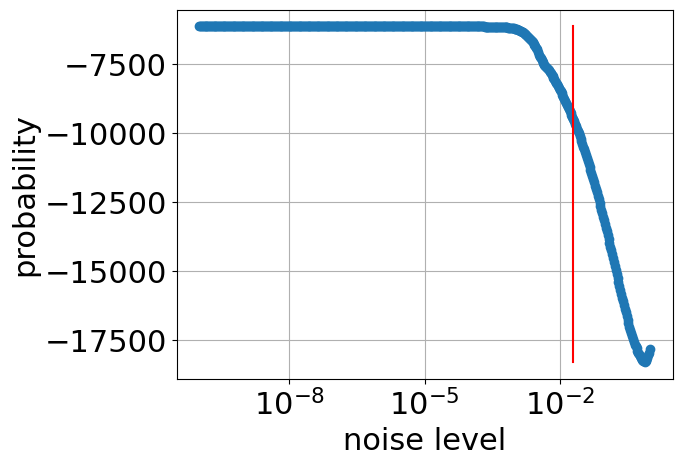

In [ ]:
plt.semilogx(SIGS,pS,'o-')
plt.grid()

plt.plot([0.02,0.02],[min(pS),max(pS)],'r')
plt.ylabel('probability')
plt.xlabel('noise level')

In [ ]:
# CALCULAMOS EL JACOBIANO
print(x_np.shape)

print(x.size())
output = log_prob(x)
J = torch.autograd.functional.jacobian(log_prob, x)
print(J.size())

(1, 3, 32, 32)
torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 3, 32, 32])


In [ ]:
J.shape

torch.Size([1, 1, 3, 32, 32])

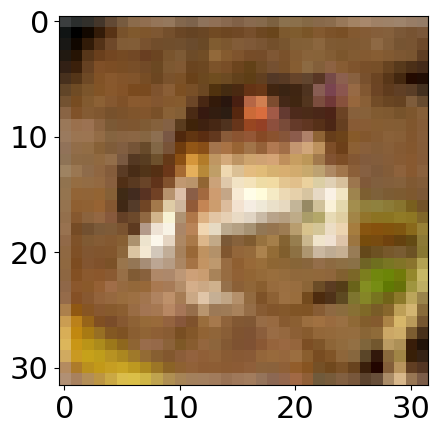

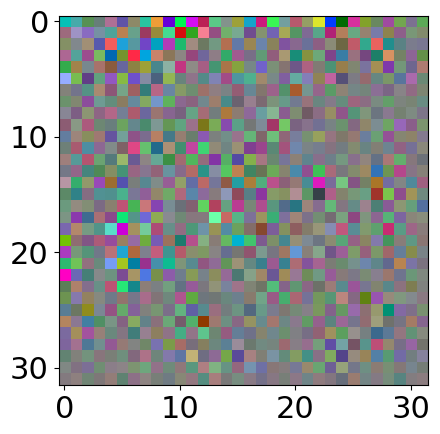

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(x_np[0], (1, 2, 0)))
plt.figure()
plt.imshow(np.transpose(J[0, 0], (1, 2, 0))/J[0, 0].max()+0.5)